## Imports

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

## Single File Analysis

In [53]:
# Load the CSV file
# file_path = '/local1/borito1907/impossibility-watermark/inputs/prompt_based_saves/prompt_1_temp_100_divp_5_attempt_1/stats.csv'
# file_path = '/local1/borito1907/impossibility-watermark/inputs/c4_saves/c4_3_temp_100_divp_5_attempt_1/stats.csv'
file_path = 'inputs/c4_saves/c4_1_temp_100_divp_20_attempt_1/stats.csv'
df = pd.read_csv(file_path)

# Function to safely convert accept_mask to a list of integers
def convert_accept_mask(mask):
    if pd.isna(mask):
        return []
    return [int(i) for i in str(mask).split(',')]

# Convert the accept_mask column to a list of integers for each row
df['accept_mask_list'] = df['accept_mask'].apply(convert_accept_mask)

# Add the new column that checks if candidate_text_lsh is in the accept_mask_list
df['is_in_accept_mask'] = df.apply(lambda row: row['candidate_text_lsh'] in row['accept_mask_list'], axis=1)

# Drop the intermediate accept_mask_list column
df.drop(columns=['accept_mask_list'], inplace=True)

# Display the updated dataframe
df.head()

,total_sentences,candidate_text,passed_margin_test,candidate_text_lsh,accept_mask,one_sentence,current_num_tries,is_in_accept_mask
0,1,She finds herself caught in the middle of a c...,True,7.0,"6,0",True,1,False
1,2,"Captain Marvel 2 is reportedly happening, and...",True,7.0,"6,0",True,2,False
2,3,Here are all the best Captain Marvel quotes a...,True,1.0,"6,0",True,3,False
3,4,It was announced today that a sequel to Capta...,True,7.0,"6,0",True,4,False
4,5,"Captain Marvel also stars Samuel L. Jackson, ...",True,2.0,"6,0",True,5,False


In [54]:
# Initialize a list to hold the results
results = []

# Initialize a counter for previous False values
previous_false_count = 0

# Iterate over the rows of the DataFrame
for index, row in df.iterrows():
    if row['is_in_accept_mask']:
        results.append({'index': index, 'previous_false_count': previous_false_count})
        previous_false_count = 0  # Reset the counter after encountering True
    else:
        previous_false_count += 1

# Create a DataFrame from the results
result_df = pd.DataFrame(results)

# Display the result DataFrame
result_df.head()

,index,previous_false_count
0,9,9
1,17,7
2,24,6
3,54,29
4,59,4


In [55]:
# Analyze one sentence

# Assuming df is your DataFrame and it includes the 'one_sentence' column
one_sentence_counts = df['one_sentence'].value_counts()

# Display the results
one_sentence_counts


True    156
Name: one_sentence, dtype: int64

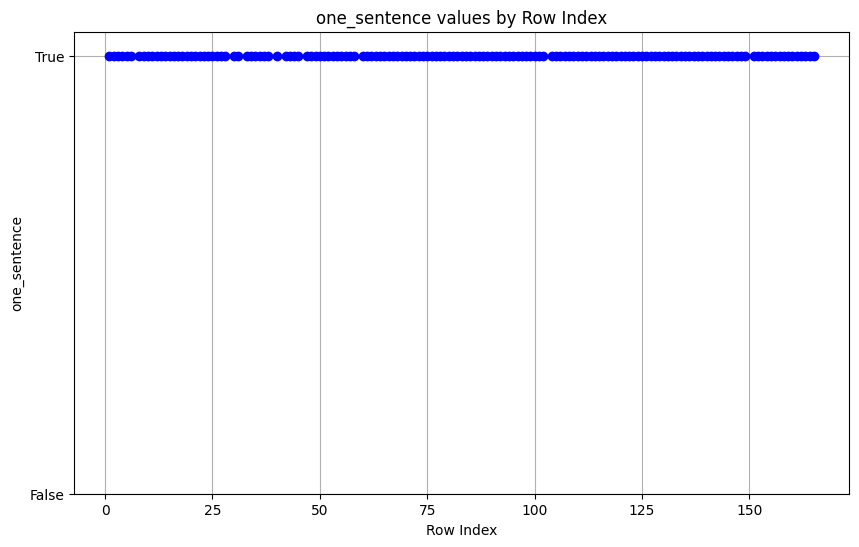

In [56]:
# Plot the one_sentence column
plt.figure(figsize=(10, 6))
plt.plot(df['total_sentences'], df['one_sentence'], marker='o', linestyle='-', color='b')
plt.xlabel('Row Index')
plt.ylabel('one_sentence')
plt.title('one_sentence values by Row Index')
plt.grid(True)
plt.yticks([0, 1], ['False', 'True'])
plt.show()

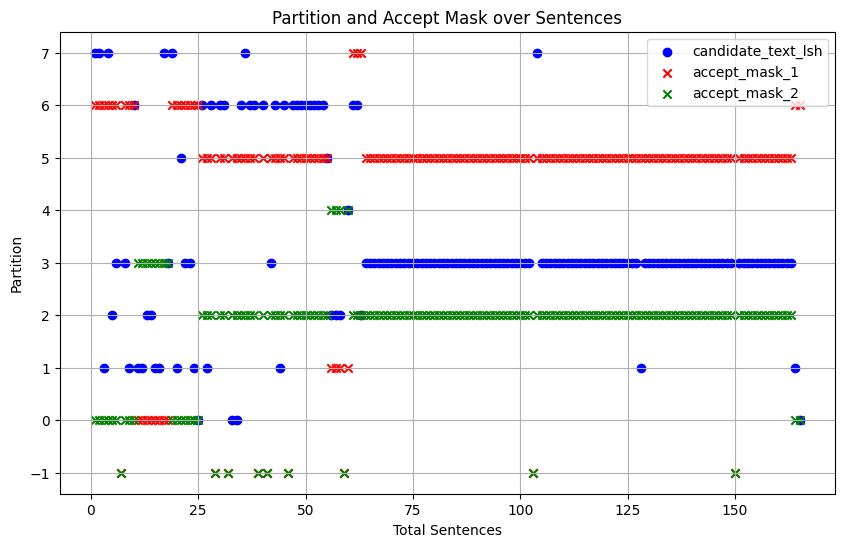

In [57]:
# Replace NaN values in 'accept_mask' with a default value
df['accept_mask'] = df['accept_mask'].fillna("-1,-1")

# Convert 'accept_mask' column from strings to two separate columns of integers
df[['accept_mask_1', 'accept_mask_2']] = df['accept_mask'].str.split(',', expand=True).astype(int)

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['total_sentences'], df['candidate_text_lsh'], color='blue', label='candidate_text_lsh')
plt.scatter(df['total_sentences'], df['accept_mask_1'], color='red', label='accept_mask_1', marker='x')
plt.scatter(df['total_sentences'], df['accept_mask_2'], color='green', label='accept_mask_2', marker='x')
plt.xlabel('Total Sentences')
plt.ylabel('Partition')
plt.title('Partition and Accept Mask over Sentences')
plt.legend()
plt.grid(True)
plt.show()

## Batch Analysis

In [58]:
# Define the base directory containing all the subdirectories
base_dir = 'inputs/tokenizer_prompt_based_saves'

# Function to safely convert accept_mask to a list of integers
def convert_accept_mask(mask):
    if pd.isna(mask):
        return []
    return [int(i) for i in str(mask).split(',')]

def check_total_sentences_increment(csv_file):
    # Load the DataFrame from the CSV file
    df = pd.read_csv(csv_file)
    
    # Check if the 'total_sentences' column is incremented by 1 at each row starting from 1
    expected_sequence = range(1, len(df) + 1)
    if not df['total_sentences'].equals(pd.Series(expected_sequence)):
        print(f"The file '{csv_file}' does not have the correct total_sentences sequence.")

# Function to process a single stats.csv file
def process_stats_file(file_path):
    df = pd.read_csv(file_path)
    
    # Convert the accept_mask column to a list of integers for each row
    df['accept_mask_list'] = df['accept_mask'].apply(convert_accept_mask)
    
    # Add the new column that checks if candidate_text_lsh is in the accept_mask_list
    df['is_in_accept_mask'] = df.apply(lambda row: row['candidate_text_lsh'] in row['accept_mask_list'], axis=1)
    
    # Drop the intermediate accept_mask_list column
    df.drop(columns=['accept_mask_list'], inplace=True)
    
    # Initialize a list to hold the results
    results = []

    # Initialize a counter for previous False values
    previous_false_count = 0

    # Iterate over the rows of the DataFrame
    for index, row in df.iterrows():
        if row['is_in_accept_mask']:
            results.append(previous_false_count)
            previous_false_count = 0  # Reset the counter after encountering True
        else:
            previous_false_count += 1

    # Create a Series from the results
    result_series = pd.Series(results)
    return result_series.mean(), result_series.max()

# Initialize a list to hold the aggregated results
aggregated_results = []

# Iterate over all subdirectories and process each stats.csv file
for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    # if os.path.isdir(subdir_path) and "prompt_3" in subdir_path:
    if os.path.isdir(subdir_path):
        stats_file_path = os.path.join(subdir_path, 'stats.csv')
        if os.path.isfile(stats_file_path):
            check_total_sentences_increment(stats_file_path)
            mean_false_count, max_false_count = process_stats_file(stats_file_path)
            temp = int(subdir.split('_')[3])
            divp = int(subdir.split('_')[5])
            aggregated_results.append({'temperature': temp, 'diversity_penalty': divp, 'mean_previous_false_count': mean_false_count, 'max_previous_false_count': max_false_count})

# Create a DataFrame from the aggregated results
aggregated_df = pd.DataFrame(aggregated_results)

# Display the aggregated DataFrame
print(aggregated_df)

# Optionally, you can save this aggregated DataFrame to a CSV file
aggregated_df.to_csv('aggregated_results.csv', index=False)


The file 'inputs/tokenizer_prompt_based_saves/prompt_1_temp_50_divp_0_attempt_1/stats.csv' does not have the correct total_sentences sequence.
The file 'inputs/tokenizer_prompt_based_saves/prompt_2_temp_50_divp_0_attempt_1/stats.csv' does not have the correct total_sentences sequence.
The file 'inputs/tokenizer_prompt_based_saves/prompt_2_temp_50_divp_10_attempt_1/stats.csv' does not have the correct total_sentences sequence.
The file 'inputs/tokenizer_prompt_based_saves/prompt_1_temp_100_divp_10_attempt_1/stats.csv' does not have the correct total_sentences sequence.
The file 'inputs/tokenizer_prompt_based_saves/prompt_4_temp_50_divp_0_attempt_2/stats.csv' does not have the correct total_sentences sequence.
The file 'inputs/tokenizer_prompt_based_saves/prompt_4_temp_50_divp_10_attempt_2/stats.csv' does not have the correct total_sentences sequence.
The file 'inputs/tokenizer_prompt_based_saves/prompt_2_temp_150_divp_20_attempt_1/stats.csv' does not have the correct total_sentences seq

In [59]:
def parse_logfile(file_path):
    z_score = None
    time_taken = None

    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()[-5:]  # Only read the last 5 lines
            for line in lines:
                if 'Score:' in line:
                    z_score = float(line.split('Score: ')[1].strip())
                if 'Time taken:' in line:
                    time_taken = float(line.split('Time taken: ')[1].strip())
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
                
    return z_score, time_taken

# Initialize a list to hold the aggregated results
aggregated_results = []

# Iterate over all subdirectories and process each logfile.log
for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    # if os.path.isdir(subdir_path) and "prompt_3" in subdir_path:
    if os.path.isdir(subdir_path):
        log_file_path = os.path.join(subdir_path, 'logfile.log')
        if os.path.isfile(log_file_path):
            z_score, time_taken = parse_logfile(log_file_path)
            temp = int(subdir.split('_')[3])
            divp = int(subdir.split('_')[5])
            aggregated_results.append({'temperature': temp, 'diversity_penalty': divp, 'z_score': z_score, 'time_taken': time_taken})

# Create a DataFrame from the aggregated results
log_df = pd.DataFrame(aggregated_results)

# Display the aggregated DataFrame
print(log_df)

# Optionally, you can save this aggregated DataFrame to a CSV file
log_df.to_csv('logfile_results.csv', index=False)


    temperature  diversity_penalty   z_score    time_taken
0            50                  0  1.825742   7235.908170
1            50                  0  1.347151  11417.867770
2            50                  0  1.414214   1983.163372
3            50                 10  1.807392   1234.602818
4            50                 20  2.449490   2016.525404
..          ...                ...       ...           ...
78           50                  0       NaN           NaN
79          180                  0  2.836833   1399.644654
80          180                  0  0.816497   1445.718227
81          180                 10       NaN           NaN
82          180                 10       NaN           NaN

[83 rows x 4 columns]


In [60]:
# Now let's find the count of rows with time_taken greater than 2, 3, 4, and 5 respectively
time_taken_less_than_2 = log_df[log_df['time_taken'] < 300.0].shape[0]
time_taken_less_than_3 = log_df[log_df['time_taken'] < 600.0].shape[0]
time_taken_less_than_4 = log_df[log_df['time_taken'] < 900.0].shape[0]
time_taken_less_than_5 = log_df[log_df['time_taken'] < 1200.0].shape[0]

time_taken_counts = {
    'time_taken < 300': time_taken_less_than_2,
    'time_taken < 600': time_taken_less_than_3,
    'time_taken < 900': time_taken_less_than_4,
    'time_taken < 1200': time_taken_less_than_5
}

time_taken_counts

{'time_taken < 300': 0,
 'time_taken < 600': 4,
 'time_taken < 900': 7,
 'time_taken < 1200': 11}

In [61]:

# Now let's find the count of rows with z_score greater than 2, 3, 4, and 5 respectively
z_score_less_than_2 = log_df[log_df['z_score'] < 2.0].shape[0]
z_score_less_than_3 = log_df[log_df['z_score'] < 3.0].shape[0]
z_score_less_than_4 = log_df[log_df['z_score'] < 4.0].shape[0]
z_score_less_than_5 = log_df[log_df['z_score'] < 5.0].shape[0]

z_score_counts = {
    'z_score < 2': z_score_less_than_2,
    'z_score < 3': z_score_less_than_3,
    'z_score < 4': z_score_less_than_4,
    'z_score < 5': z_score_less_than_5
}

z_score_counts

{'z_score < 2': 41, 'z_score < 3': 66, 'z_score < 4': 72, 'z_score < 5': 78}

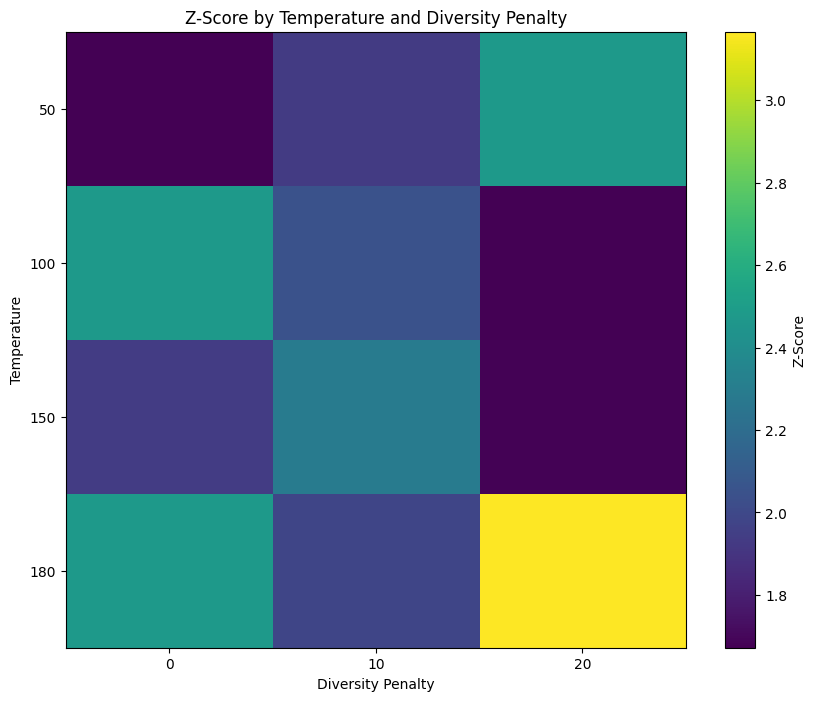

diversity_penalty,0,10,20
temperature,,,
50,1.671819,1.932557,2.477407
100,2.480751,2.046579,1.672051
150,1.935611,2.295431,1.679236
180,2.477873,1.984745,3.166102


In [62]:
log_df = log_df.dropna()

# Create a pivot table for the z-score
pivot_table_z_score = log_df.pivot_table(
    values='z_score',
    index='temperature',
    columns='diversity_penalty',
    aggfunc='mean'
)

# Plotting the pivot table as a heatmap
plt.figure(figsize=(10, 8))
plt.title('Z-Score by Temperature and Diversity Penalty')
plt.xlabel('Diversity Penalty')
plt.ylabel('Temperature')
plt.imshow(pivot_table_z_score, cmap='viridis', aspect='auto')
plt.colorbar(label='Z-Score')
plt.xticks(ticks=range(len(pivot_table_z_score.columns)), labels=pivot_table_z_score.columns)
plt.yticks(ticks=range(len(pivot_table_z_score.index)), labels=pivot_table_z_score.index)
plt.show()

pivot_table_z_score


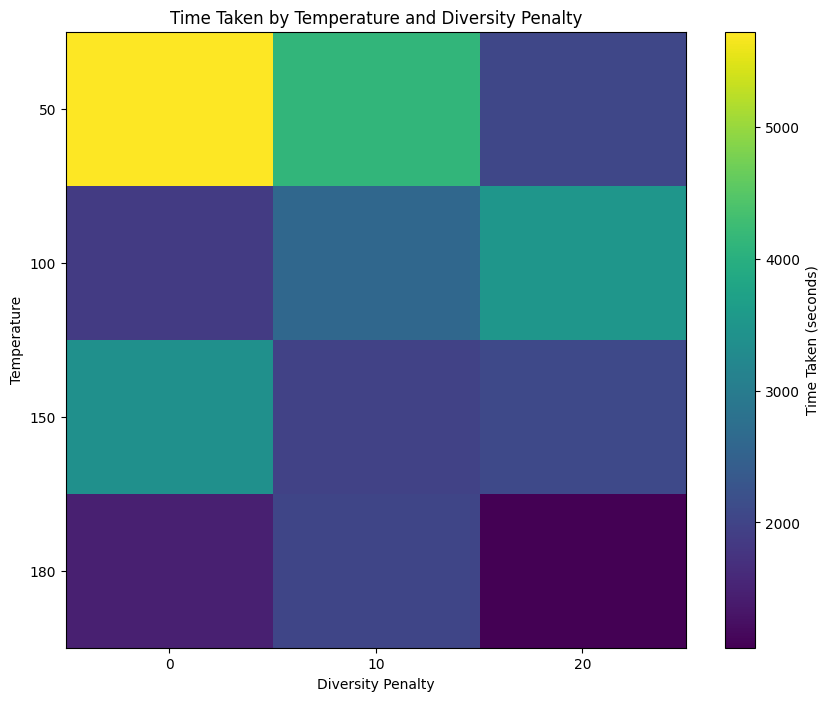

diversity_penalty,0,10,20
temperature,,,
50,5725.487532,4135.283278,2053.326717
100,1868.728230,2602.180105,3499.493150
150,3401.125329,1977.297042,2085.521657
180,1452.500406,2033.326861,1048.841136


In [63]:
# Create a pivot table for the time taken
pivot_table_time_taken = log_df.pivot_table(
    values='time_taken',
    index='temperature',
    columns='diversity_penalty',
    aggfunc='mean'
)

# Plotting the pivot table as a heatmap
plt.figure(figsize=(10, 8))
plt.title('Time Taken by Temperature and Diversity Penalty')
plt.xlabel('Diversity Penalty')
plt.ylabel('Temperature')
plt.imshow(pivot_table_time_taken, cmap='viridis', aspect='auto')
plt.colorbar(label='Time Taken (seconds)')
plt.xticks(ticks=range(len(pivot_table_time_taken.columns)), labels=pivot_table_time_taken.columns)
plt.yticks(ticks=range(len(pivot_table_time_taken.index)), labels=pivot_table_time_taken.index)
plt.show()

pivot_table_time_taken


## Quality Analysis

In [64]:
def parse_quality_logfile(file_path):
    score_pattern = re.compile(r"Score:\s*(\d+)")
    
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
    # Find the last non-empty line
    for line in reversed(lines):
        if line.strip():  # Check if the line is not just whitespace
            match = score_pattern.search(line)
            if match:
                return int(match.group(1))
    
    # If no score is found, raise an exception
    raise ValueError("No score found in the log file")

# Initialize a list to hold the aggregated results
aggregated_results = []

# Iterate over all subdirectories and process each logfile.log
for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    # if os.path.isdir(subdir_path) and "prompt_3" in subdir_path:
    if os.path.isdir(subdir_path):
        log_file_path = os.path.join(subdir_path, 'quality_logfile.log')
        if os.path.isfile(log_file_path):
            quality_score = parse_quality_logfile(log_file_path)
            temp = int(subdir.split('_')[3])
            divp = int(subdir.split('_')[5])
            aggregated_results.append({'temperature': temp, 'diversity_penalty': divp, 'quality_score': quality_score})

# Create a DataFrame from the aggregated results
quality_df = pd.DataFrame(aggregated_results)

# Display the aggregated DataFrame
print(quality_df)

# Optionally, you can save this aggregated DataFrame to a CSV file
quality_df.to_csv('prompt_based_quality_result.csv', index=False)


Empty DataFrame
Columns: []
Index: []


In [65]:
# Create a pivot table for the time taken
pivot_table_quality = quality_df.pivot_table(
    values='quality_score',
    index='temperature',
    columns='diversity_penalty',
    aggfunc='mean'
)

# Plotting the pivot table as a heatmap
plt.figure(figsize=(10, 8))
plt.title('Quality Score by Temperature and Diversity Penalty')
plt.xlabel('Diversity Penalty')
plt.ylabel('Temperature')
plt.imshow(pivot_table_quality, cmap='viridis', aspect='auto')
plt.colorbar(label='Quality Score')
plt.xticks(ticks=range(len(pivot_table_quality.columns)), labels=pivot_table_quality.columns)
plt.yticks(ticks=range(len(pivot_table_quality.index)), labels=pivot_table_quality.index)
plt.show()

pivot_table_quality


KeyError: 'quality_score'